In [1]:
!pip3 install folium

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def make_date(df):
  return datetime.date(df.YEAR, df.MONTH, df.DAY)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.dDate.dt.year
    data['month'] = data.dDate.dt.month
    data['day'] = data.dDate.dt.day
    data['dayofweek'] = data.dDate.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

In [3]:
df_L_airport = pd.read_csv('L_AIRPORT.csv', dtype={'CODE':str})
df_L_airport_ID = pd.read_csv('L_AIRPORT_ID.csv', dtype={'CODE':str})

In [4]:
df_L_airport =  df_L_airport_ID.merge(df_L_airport, on="Description", how='inner')
df_L_airport.Code_x = df_L_airport.Code_x.astype(str)

df_L_airport.rename(columns={'Code_x': 'Code_num', 'Code_y': 'Code_IATA'}, inplace=True)
df_L_airport = df_L_airport.drop_duplicates(subset=['Code_num'])
df_L_airport.reset_index(drop=True, inplace=True)

In [5]:
df_L_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6383 entries, 0 to 6382
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code_num     6383 non-null   object
 1   Description  6383 non-null   object
 2   Code_IATA    6383 non-null   object
dtypes: object(3)
memory usage: 149.7+ KB


In [6]:
df_L_airport

,Code_num,Description,Code_IATA
0,10001,"Afognak Lake, AK: Afognak Lake Airport",01A
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip",03A
2,10004,"Lik, AK: Lik Mining Camp",04A
3,10005,"Little Squaw, AK: Little Squaw Airport",05A
4,10006,"Kizhuyak, AK: Kizhuyak Bay",06A
...,...,...,...
6378,16748,"Doylestown, PA: Doylestown Airport",DYL
6379,16749,"China Spring, TX: Wildcat Canyon",T7X
6380,16750,"Sanford, NC: Raleigh Exec Jetport at Sanford L...",N4C
6381,16751,"Placida, FL: Coral Creek",FL7


In [7]:
# Все перелеты
df_flights=pd.read_csv('flights.csv', dtype={'ORIGIN_AIRPORT':str, 'DESTINATION_AIRPORT':str})

In [8]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [9]:
df_flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [10]:
# Заменяем на 0 пустые значения
df_flights['AIRLINE_DELAY'] = df_flights['AIRLINE_DELAY'].fillna(0)
df_flights['AIR_SYSTEM_DELAY'] = df_flights['AIR_SYSTEM_DELAY'].fillna(0)
df_flights['SECURITY_DELAY'] = df_flights['SECURITY_DELAY'].fillna(0)
df_flights['LATE_AIRCRAFT_DELAY'] = df_flights['LATE_AIRCRAFT_DELAY'].fillna(0)
df_flights['WEATHER_DELAY'] = df_flights['WEATHER_DELAY'].fillna(0)

# Причины отмены рейсов заменям на коды
# NaN = 0 A = 1 B = 2 C = 3 D = 4
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'A', 'CANCELLATION_REASON'] = 1
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'B', 'CANCELLATION_REASON'] = 2
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'C', 'CANCELLATION_REASON'] = 3
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'D', 'CANCELLATION_REASON'] = 4
df_flights['CANCELLATION_REASON'] = df_flights['CANCELLATION_REASON'].fillna(0)

# удаляем оставшиеся пустые строки
df_flights = df_flights.dropna(axis=0)

In [11]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [12]:
# Замена пятизначных кодов аэропортов на коды IATA
df_L_airport.Code_num = df_L_airport.Code_num.astype(str)
df_L_airport = df_L_airport.set_index('Code_num')

def convert_airports(df):
    cond_origin = (df.ORIGIN_AIRPORT.apply(len) == 5)
    f= lambda x: df_L_airport.loc[str(x), 'Code_IATA']
    df.loc[cond_origin, 'ORIGIN_AIRPORT'] = df.loc[cond_origin, 'ORIGIN_AIRPORT'].map(f)
    
    cond_dest = (df.DESTINATION_AIRPORT.apply(len) == 5)
    df.loc[cond_dest, 'DESTINATION_AIRPORT'] = df.loc[cond_dest, 'DESTINATION_AIRPORT'].map(f)
    return df

# вызываем функцию для перевода ORIGIN_AIRPORT, DESTINATION_AIRPORT в формат IATA_CODE
df_flights = convert_airports(df_flights)

In [13]:
# проверяем, что в перелетах df_flights не осталось 5-значных кодов аэропортов
df_flights_num = df_flights[df_flights['ORIGIN_AIRPORT'].str.len().between(4, 6) | df_flights['DESTINATION_AIRPORT'].str.len().between(4, 6)]
df_flights_num

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY


In [14]:
# Аэропорты
df_airports = pd.read_csv('airports.csv')

In [15]:
# объединяем перелеты с аэропортами отправления
df_flights = df_flights.merge(df_airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')

In [16]:
df_flights.rename(columns={'AIRPORT': 'ORIG_AIRPORT_NAME', 
                           'CITY': 'ORIG_AIRPORT_CITY', 
                           'STATE': 'ORIG_AIRPORT_STATE', 
                           'LATITUDE': 'ORIG_AIRPORT_LAT', 
                           'LONGITUDE': 'ORIG_AIRPORT_LONG'}, inplace=True)

df_flights = df_flights.drop ('IATA_CODE', axis=1)
df_flights = df_flights.drop ('COUNTRY', axis=1)

In [17]:
# Создадим копию датафрейма, чтобы в нем обнулить вылеты ранее расписания
fly_airFrom = df_flights.copy(deep=True)

In [18]:
# Вылеты, совершённые раньше, чем по расписанию, считаем совершёнными по расписанию
fly_airFrom['DEPARTURE_DELAY'] = np.maximum(fly_airFrom.DEPARTURE_DELAY, 0)

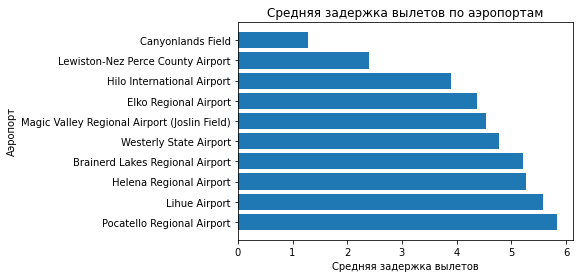

In [19]:
# Среднее время задержки вылетов в разрезе ТОП-10 аэропортов
dep_data = fly_airFrom.groupby('ORIG_AIRPORT_NAME').mean()['DEPARTURE_DELAY'].sort_values(ascending=[False]).tail(10)
plt.barh(y = dep_data.index, width = dep_data.values)
plt.xlabel("Средняя задержка вылетов")
plt.ylabel("Аэропорт")
plt.title("Средняя задержка вылетов по аэропортам")
plt.show()

In [20]:
dep_data = pd.DataFrame(dep_data)
dep_data = dep_data.reset_index()

In [21]:
dep_data

,ORIG_AIRPORT_NAME,DEPARTURE_DELAY
0,Pocatello Regional Airport,5.829337
1,Lihue Airport,5.581346
2,Helena Regional Airport,5.275641
3,Brainerd Lakes Regional Airport,5.211024
4,Westerly State Airport,4.778846
5,Magic Valley Regional Airport (Joslin Field),4.531390
6,Elko Regional Airport,4.371930
7,Hilo International Airport,3.906134
8,Lewiston-Nez Perce County Airport,2.404056
9,Canyonlands Field,1.282927


### Вывод: аэропорт с минимальной средней задержкой вылета - Canyonlands Field

In [22]:
airport_data = df_airports.loc[df_airports['AIRPORT'].isin(dep_data['ORIG_AIRPORT_NAME'])]

In [23]:
import folium
from folium.features import DivIcon

# Отметим найденные аэропорты на карте
# Создадим список кортежей широты и долготы и список для хранения кода IATA
lat_lon_pairs = []
airport_code = []
for i in range(airport_data.shape[0]):
    
    # Добавляем в список пары широт и долгот
    lat_i = airport_data['LATITUDE'].iloc[i]
    lon_i = airport_data['LONGITUDE'].iloc[i]
    lat_lon_pair = (lat_i, lon_i)
    lat_lon_pairs.append(lat_lon_pair)
    
    # Добавляем в список IATA коды аэропортов
    iata_i = airport_data['IATA_CODE'].iloc[i]
    airport_code.append(iata_i)
    
usa_lat = 32.37496
usa_lon = -103.29484

usa_map = folium.Map(location=(usa_lat, usa_lon), width=800, height=500, zoom_start=2.5, max_zoom=14)

# Отмечаем на карте IATA коды аэропортов
html = '<div style="color:grey;font-size: 8pt;width: 35%;">airport_code</div>'
for loc, air_code in zip(lat_lon_pairs, airport_code):
    folium.Marker(loc, icon=DivIcon(
                       icon_size=(5,5),
                       icon_anchor=(0,0),
                       html=html.replace('airport_code', air_code),
                        )).add_to(usa_map)
    
# Отмечаем широту и долготу
for loc, air_code in zip(lat_lon_pairs, airport_code):
    folium.Marker(loc).add_to(usa_map)
    
usa_map

### Задание №2. Определить самую пунктуальную авиакомпанию на прилет в Los Angeles International Airport

In [24]:
# объединяем перелеты с аэропортами прибытия
df_flights = df_flights.merge(df_airports, left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')

In [25]:
# Авиакомпании
df_airlines = pd.read_csv('airlines.csv')

In [26]:
# объединяем перелеты с авиакомпаниями
df_flights = df_flights.merge(df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [27]:
df_flights.rename(columns={'AIRPORT': 'DEST_AIRPORT_NAME', 
                           'CITY': 'DEST_AIRPORT_CITY', 
                           'STATE': 'DEST_AIRPORT_STATE', 
                           'LATITUDE': 'DEST_AIRPORT_LAT', 
                           'LONGITUDE': 'DEST_AIRPORT_LONG', 
                           'AIRLINE_y': 'AIRLINE', 
                           'AIRLINE_x': 'AIRLINE_IATA'}, inplace=True)

df_flights = df_flights.drop(['IATA_CODE_x','IATA_CODE_y','COUNTRY'], axis=1)

In [61]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_IATA,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ORIG_AIRPORT_STATE,ORIG_AIRPORT_LAT,ORIG_AIRPORT_LONG,DEST_AIRPORT_NAME,DEST_AIRPORT_CITY,DEST_AIRPORT_STATE,DEST_AIRPORT_LAT,DEST_AIRPORT_LONG,AIRLINE,dDate
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01
2,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01
3,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,...,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01
4,2015,1,1,4,AS,730,N423AS,ANC,SEA,505,...,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01


In [29]:
flights_ToLA = df_flights[df_flights.DEST_AIRPORT_NAME == 'Los Angeles International Airport']

In [30]:
# Вычисляем абсолютное время отклонения прилета от расписания в столбец how_deviation
flights_ToLA.loc[:, 'how_deviation'] = flights_ToLA.loc[:, 'ARRIVAL_DELAY'].abs()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
flights_ToLA

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_IATA,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ORIG_AIRPORT_STATE,ORIG_AIRPORT_LAT,ORIG_AIRPORT_LONG,DEST_AIRPORT_NAME,DEST_AIRPORT_CITY,DEST_AIRPORT_STATE,DEST_AIRPORT_LAT,DEST_AIRPORT_LONG,AIRLINE,how_deviation
98415,2015,1,1,4,AS,150,N528AS,ANC,LAX,2340,...,AK,61.17432,-149.99619,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Alaska Airlines Inc.,33.0
98416,2015,1,2,5,AS,150,N442AS,ANC,LAX,2340,...,AK,61.17432,-149.99619,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Alaska Airlines Inc.,42.0
98417,2015,1,3,6,AS,150,N596AS,ANC,LAX,2340,...,AK,61.17432,-149.99619,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Alaska Airlines Inc.,29.0
98418,2015,1,4,7,AS,150,N553AS,ANC,LAX,2340,...,AK,61.17432,-149.99619,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Alaska Airlines Inc.,111.0
98419,2015,1,8,4,AS,150,N557AS,ANC,LAX,2340,...,AK,61.17432,-149.99619,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Alaska Airlines Inc.,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500651,2015,12,26,6,MQ,3248,N522MQ,ASE,LAX,1845,...,CO,39.22316,-106.86885,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,American Eagle Airlines Inc.,44.0
5500652,2015,12,28,1,MQ,3248,N520MQ,ASE,LAX,1845,...,CO,39.22316,-106.86885,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,American Eagle Airlines Inc.,146.0
5500653,2015,12,29,2,MQ,3248,N520MQ,ASE,LAX,1845,...,CO,39.22316,-106.86885,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,American Eagle Airlines Inc.,83.0
5500654,2015,12,30,3,MQ,3248,N515MQ,ASE,LAX,1845,...,CO,39.22316,-106.86885,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,American Eagle Airlines Inc.,1076.0


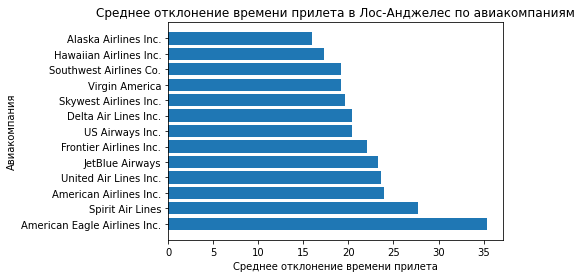

In [32]:
# Среднее время отклонения прилета в ЛА в разрезе авиакомпаний
dep_data = flights_ToLA.groupby('AIRLINE').mean()['how_deviation'].sort_values(ascending=[False])

plt.barh(y = dep_data.index, width = dep_data.values)
plt.xlabel("Среднее отклонение времени прилета")
plt.ylabel("Авиакомпания")
plt.title("Среднее отклонение времени прилета в Лос-Анджелес по авиакомпаниям")
plt.show()

#### Вывод: самая пунктуальная авиакомпания на прилет в Los Angeles International Airport - Alaska Airlines Inc.

### Задание №3. Определить аэропорт с самой большой долей руления на 1 самолетовылет

In [33]:
df = df_flights.groupby('ORIG_AIRPORT_NAME').agg({'FLIGHT_NUMBER': ['count'], 
                                         'TAXI_OUT': ['sum'], 
                                         'TAXI_IN': ['sum'], 
                                         'ELAPSED_TIME': ['sum']}).reset_index()

df.columns = ['ORIG_AIRPORT_NAME', 'FLIGHT_cnt', 'TAXI_OUT_sum', 'TAXI_IN_sum', 'ELAPSED_sum']

In [34]:
# Вычисляем долю руления на 1 самолетовылет в столбце share_of_taxiing
df.loc[:, 'share_of_taxiing'] = (df['TAXI_OUT_sum'] + df['TAXI_IN_sum'])/df['ELAPSED_sum']

In [35]:
df_head_10 = df.sort_values(by='share_of_taxiing', ascending=False).head(10)
df_head_10

,ORIG_AIRPORT_NAME,FLIGHT_cnt,TAXI_OUT_sum,TAXI_IN_sum,ELAPSED_sum,share_of_taxiing
124,Gustavus Airport,76,718.0,369.0,2173.0,0.500230
203,Muskegon County Airport,680,9747.0,9268.0,39404.0,0.482565
37,Brainerd Lakes Regional Airport,635,12164.0,3488.0,32686.0,0.478859
185,McClellan-Palomar Airport,628,7833.0,5675.0,28932.0,0.466888
81,Dubuque Regional Airport,956,11548.0,15307.0,57555.0,0.466597
97,Flagstaff Pulliam Airport,1766,30372.0,12774.0,92605.0,0.465914
235,Pueblo Memorial Airport,253,2978.0,2773.0,12570.0,0.457518
308,Wichita Falls Municipal Airport/Sheppard AFB,1287,15322.0,13430.0,63023.0,0.456214
162,Laramie Regional Airport,608,8729.0,4638.0,29435.0,0.454119
63,Columbus Metropolitan Airport,1172,13709.0,9523.0,51742.0,0.448997


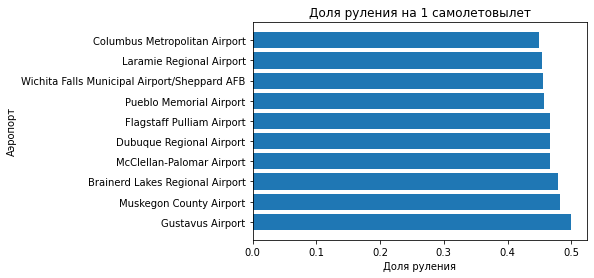

In [36]:
plt.barh(y = df_head_10.ORIG_AIRPORT_NAME, width = df_head_10.share_of_taxiing)
plt.xlabel("Доля руления")
plt.ylabel("Аэропорт")
plt.title("Доля руления на 1 самолетовылет")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

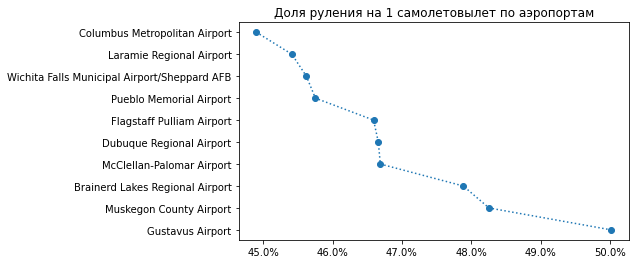

In [65]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot()
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f%%'))
ax.set_title('Доля руления на 1 самолетовылет по аэропортам')
x =  (100*(df_head_10.loc[:, ['share_of_taxiing']])) 
y = df_head_10.loc[:, 'ORIG_AIRPORT_NAME']
plt.plot(x, y, ':o')
plt.show

### Вывод: Аэропорт с самой большой долей руления на 1 самолетовылет - Gustavus Airport

### Задание 4. Построить модель, которая будет выбирать топ-3 аэропорта прилета в зависимости от аэропорта вылета (вероятность опоздания минимальная – RMSE метрика)


In [134]:
%%time
# Создаем столбец с датой, группируем по дате и аэропорту прилета, суммируем задержку вылета 
df_flights['dDate'] = df_flights.apply(make_date,axis = 1)
flight_grouped = df_flights.groupby(['dDate','DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].sum().reset_index()
flight_grouped['dDate'] = pd.to_datetime(flight_grouped['dDate'])

Wall time: 47 ms


In [135]:
%%time
from sklearn.ensemble import RandomForestRegressor
where_to_go = []
for dest in flight_grouped.DESTINATION_AIRPORT.unique():
    tempo = flight_grouped[flight_grouped.DESTINATION_AIRPORT==dest][['dDate','ARRIVAL_DELAY']]
    tempo.columns = ['dDate','ARRIVAL_DELAY']
    tempo = pd.DataFrame(tempo)
    
    try:
    
        make_features(tempo,10,3)
        tempo.dropna(inplace=True)
        tempo.set_index('dDate',inplace=True)
        
        # Разделяем на тестовый и обучающий набор
        X_train,X_test,y_train, y_test = train_test_split(tempo.drop('ARRIVAL_DELAY', axis=1),
                                                          tempo.ARRIVAL_DELAY, 
                                                          shuffle=False, 
                                                          test_size=0.25)

        model_lr = RandomForestRegressor(n_estimators = 10)
        #model_lr = GradientBoostingRegressor()
        # Обучаем
        model_lr.fit(X_train,y_train)
        
        # Предсказываем
        y_predicted_lr = model_lr.predict(X_test)
        where_to_go.append([dest, y_test.mean(), np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except Exception as e:
        print('Error', str(e))

Wall time: 1min 14s


In [136]:
%%time
where_to_go = pd.DataFrame(where_to_go)
where_to_go.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']

Wall time: 2.99 ms


In [131]:
%%time
start_airport = np.random.choice(df_flights['ORIGIN_AIRPORT'].unique()) 
where_to_go_from_start_airport = df_flights[df_flights.ORIGIN_AIRPORT==start_airport]['DESTINATION_AIRPORT'].unique()

where_to_go_from_start_airport = pd.DataFrame(where_to_go_from_start_airport)
where_to_go_from_start_airport.columns = ['DESTINATION_AIRPORT']

top3 = where_to_go_from_start_airport\
    .merge(where_to_go,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)

print('Лучшие направления из аэропорта',start_airport)
print('')
print(top3)

Лучшие направления из аэропорта RAP

  DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_IN_PAST         RMSE
1                 SLC                   83.415730  1797.605974
0                 MSP                  333.752809  2922.426140
4                 IAH                 1241.674157  4946.659456
Wall time: 342 ms


In [139]:
from sklearn.model_selection import GridSearchCV

tree_para = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [140]:
clf_gs = GridSearchCV(RandomForestRegressor(), tree_para, cv=5, scoring = 'neg_mean_squared_error')
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [141]:
clf_gs.best_params_

{'max_features': 6, 'n_estimators': 10}

In [149]:
clf_gs.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=10)

In [142]:
model_new = RandomForestRegressor(**clf_gs.best_params_)

In [143]:
model_new.fit(X_train,y_train)

RandomForestRegressor(max_features=6, n_estimators=10)

In [144]:
new_pred = model_new.predict(X_test)

In [145]:
cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
scores = cross_val_score(model_new, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

In [146]:
scores.mean()

-1585.0144444444445